# Library for the Satellite images

> Indented block



## Bands
ToDo: Single band <- 7 bands,



In [ ]:
!pip install earthpy

In [3]:
pip install pyrsgis==0.3.9

## Data Prepration and pre-processing

In [1]:
import numpy as np
import random
# import sklearn
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray

# Defining file names
featureFile = 'Playa_Image.tif'
# labelFile = 'Playa_Image_Training.tif'

# Reading and normalizing input data
dsFeatures, arrFeatures = raster.read(featureFile, bands='all')
arrFeatures = arrFeatures.astype(float)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i][:][:].min()
    bandMax = arrFeatures[i][:][:].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures[i][j][k] = (arrFeatures[i][j][k]-bandMin)/bandRange

# Creating chips using pyrsgis
features = imageChipsFromArray(arrFeatures, x_size=7, y_size=7)

Warning! matplotlib_scalebar library not found. You may not be able to export map directly.


In [2]:
import matplotlib.pyplot as plt
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray, imageChipsFromFile
import torch.nn as nn
import torch
# Defining the function to split features and labels
def train_test_split(features,  trainProp=0.75):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    # train_y = labels[randIndex[:sliceIndex]]
    # test_y = labels[randIndex[sliceIndex:]]
    return(train_x,  test_x, )

# Calling the function to split the data
train_x, test_x = train_test_split(features)

## Dataloader

In [3]:
data_loader = torch.utils.data.DataLoader(train_x,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)


In [14]:
# mnist_data = MNIST(root='./', download=True, transform=transforms.ToTensor())
import matplotlib.pyplot as plt
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray, imageChipsFromFile
import torch.nn as nn
import torch

# read the TIF file(s) (both are of different sizes - for demonstration)
single_band_file = r'Playa_Image.tif' # this is a Landsat 5 TM image (7 bands stacked)
# multi_band_file = r'Playa_Image.tif' # this is a Landsat 5 TM image (7 bands stacked)

# create image chips
single_band_chips = imageChipsFromFile(single_band_file, x_size=28, y_size=28)
# multi_band_chips = imageChipsFromFile(multi_band_file, x_size=16, y_size=16)

print(single_band_chips.shape)
# print(multi_band_chips.shape)
print(single_band_chips[1].shape)

(189658, 28, 28, 7)
(28, 28, 7)


In [15]:
print(len(single_band_chips))

189658


## Change datatype

In [16]:
import numpy as np
import cv2 
import tensorflow as tf


# changin the type of data images 
single_band_chips        = np.rollaxis(single_band_chips, 3, 1)
single_band_chips_float  = single_band_chips.astype(np.float32)

single_band_chips_tensor = torch.as_tensor(single_band_chips_float)

print(single_band_chips_tensor.dtype)

print('no of chips: bends: h: W ',single_band_chips.shape)

torch.float32
no of chips: bends: h: W  (189658, 7, 28, 28)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from utils import ACTIVATION_DERIVATIVES
import math
import torch
# from flows import RadialFlow, PlanarFlow
from tqdm import tqdm
import torch.nn.functional as F
# from models import FCNEncoder, FCNDecoder, FlowModel
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from matplotlib import pyplot as plt
from scipy.special import logsumexp
import numpy as np
from sklearn.datasets import make_moons
from matplotlib import collections  as mc

## VAE Flow model

In [5]:
from typing import List
class FCNEncoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        
        hidden_sizes = [dim_input] + hidden_sizes
        
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

        
    def forward(self, x):
        return self.net(x)

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal

class FlowModel(nn.Module):
    def __init__(self, flows: List[str], D: int, activation=torch.tanh):
        super().__init__()
        
        self.prior = MultivariateNormal(torch.zeros(D), torch.eye(D))
        self.net = []

        for i in range(len(flows)):
            layer_class = eval(flows[i])
            self.net.append(layer_class(D, activation))

        self.net = nn.Sequential(*self.net)

        self.D = D


    def forward(self, mu: torch.Tensor, log_sigma: torch.Tensor):
        """
        mu: tensor with shape (batch_size, D)
        sigma: tensor with shape (batch_size, D)
        """
        sigma = torch.exp(log_sigma)
        batch_size = mu.shape[0]
        samples = self.prior.sample(torch.Size([batch_size]))
        # print(samples.size, sigma.shape)
        z = samples * sigma + mu

        z0 = z.clone().detach()
        log_prob_z0 = torch.sum(
            -0.5 * torch.log(torch.tensor(2 * math.pi)) - 
            log_sigma - 0.5 * ((z - mu) / sigma) ** 2, 
            axis=1)
        
        log_det = torch.zeros((batch_size,))
        
        for layer in self.net:
            z, ld = layer(z)
            log_det += ld

        log_prob_zk = torch.sum(
            -0.5 * (torch.log(torch.tensor(2 * math.pi)) + z ** 2), 
            axis=1)

        return z, log_prob_z0, log_prob_zk, log_det

In [7]:
ACTIVATION_DERIVATIVES = {
    F.elu: lambda x: torch.ones_like(x) * (x >= 0) + torch.exp(x) * (x < 0),
    torch.tanh: lambda x: 1 - torch.tanh(x) ** 2
}

class PlanarFlow(nn.Module):
    def __init__(self, D, activation=torch.tanh):
        super().__init__()
        self.D = D
        self.w = nn.Parameter(torch.empty(D))
        self.b = nn.Parameter(torch.empty(1))
        self.u = nn.Parameter(torch.empty(D))
        self.activation = activation
        self.activation_derivative = ACTIVATION_DERIVATIVES[activation]

        nn.init.normal_(self.w)
        nn.init.normal_(self.u)
        nn.init.normal_(self.b)

    def forward(self, z: torch.Tensor):
        lin = (z @ self.w + self.b).unsqueeze(1)  # shape: (B, 1)
        f = z + self.u * self.activation(lin)  # shape: (B, D)
        phi = self.activation_derivative(lin) * self.w  # shape: (B, D)
        log_det = torch.log(torch.abs(1 + phi @ self.u) + 1e-4) # shape: (B,)
        

        return f, log_det


class RadialFlow(nn.Module):
    def __init__(self, D, activation=torch.tanh):
        super().__init__()

        self.z0 = nn.Parameter(torch.empty(D))
        self.log_alpha = nn.Parameter(torch.empty(1))
        self.beta = nn.Parameter(torch.empty(1))
        self.activation = activation
        self.activation_derivative = ACTIVATION_DERIVATIVES[activation]
        self.D = D

        nn.init.normal_(self.z0) 
        nn.init.normal_(self.log_alpha)
        nn.init.normal_(self.beta)


    def forward(self, z: torch.Tensor):
        z_sub = z - self.z0
        alpha = torch.exp(self.log_alpha)
        r = torch.norm(z_sub)
        h = 1 / (alpha + r)
        f = z + self.beta * h * z_sub
        log_det = (self.D - 1) * torch.log(1 + self.beta * h) + \
            torch.log(1 + self.beta * h + self.beta - self.beta * r / (alpha + r) ** 2)

        return f, log_det

In [8]:
class FCNDecoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        hidden_sizes = [dim_input] + hidden_sizes
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

    def forward(self, z: torch.Tensor):
        return self.net(z)

In [26]:
D = 40 # Depth (No. of channels)
encoder = FCNEncoder(hidden_sizes=[128, 64, 2*D], dim_input=7*7*7)
flow_model = FlowModel(flows=['PlanarFlow'] * 10, D=40)
decoder = FCNDecoder(hidden_sizes=[64, 128, 343], dim_input=40)
# optimizer Adam
optimizer = optim.Adam(list(encoder.parameters()) + list(flow_model.parameters()) + list(decoder.parameters()))

## Training of the model

In [27]:
loss_fn = BCEWithLogitsLoss()
running_loss = []
for i, X_batch in enumerate(data_loader):
    optimizer.zero_grad()
    out = encoder(X_batch.view(-1, 7*49).float())
    mu, log_sigma = out[:, :40], out[:, 40:]
    z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
    x_hat = decoder(z_k)
    # print(x_hat.shape)
    # print(X_batch.shape)
    
    loss = torch.mean(log_prob_z0) + loss_fn(x_hat, X_batch.view(-1, 343).float()) - torch.mean(log_prob_zk) - torch.mean(log_det)
    if i % 100 == 0:
        print(f'Iteration {i}, loss: {loss.item()}')
        running_loss.append(loss)
    
    loss.backward()
    optimizer.step()

Iteration 0, loss: 219.13465881347656
Iteration 100, loss: 170.40640258789062
Iteration 200, loss: 141.54542541503906
Iteration 300, loss: 111.38267517089844
Iteration 400, loss: 89.8583984375
Iteration 500, loss: 79.28489685058594
Iteration 600, loss: 73.37884521484375
Iteration 700, loss: 60.26276779174805
Iteration 800, loss: 50.16343307495117
Iteration 900, loss: 49.55780792236328
Iteration 1000, loss: 49.9427490234375
Iteration 1100, loss: 45.19700622558594
Iteration 1200, loss: 39.487762451171875
Iteration 1300, loss: 34.3146858215332
Iteration 1400, loss: 42.74226760864258
Iteration 1500, loss: 33.17182159423828
Iteration 1600, loss: 24.305044174194336
Iteration 1700, loss: 16.43391990661621
Iteration 1800, loss: 15.894693374633789
Iteration 1900, loss: 13.634346961975098
Iteration 2000, loss: 9.947776794433594
Iteration 2100, loss: 24.665428161621094
Iteration 2200, loss: 14.912765502929688
Iteration 2300, loss: 9.133270263671875
Iteration 2400, loss: 6.57927131652832
Iteration

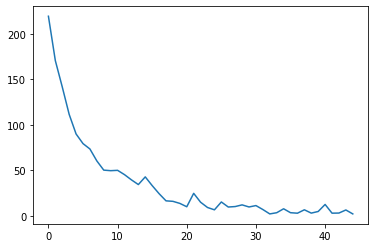

In [28]:
plt.plot(running_loss)

In [24]:
out = encoder(X_batch.view(-1, 343).float())
mu, log_sigma = out[:, :D], out[:, D:]
z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
x_hat = decoder(z_k)

loss = torch.mean(log_prob_z0) + loss_fn(x_hat, X_batch.view(-1, 343).float()) - torch.mean(log_prob_zk) - torch.mean(log_det)
print(loss)

tensor(2.0599, grad_fn=<SubBackward0>)


# Trash

In [ ]:
import numpy as np
import random
# import sklearn
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray

# Defining file names
featureFile = 'Playa_Image.tif'
# labelFile = 'Playa_Image_Training.tif'

# Reading and normalizing input data
dsFeatures, arrFeatures = raster.read(featureFile, bands='all')
arrFeatures = arrFeatures.astype(float)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i][:][:].min()
    bandMax = arrFeatures[i][:][:].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures[i][j][k] = (arrFeatures[i][j][k]-bandMin)/bandRange

# Creating chips using pyrsgis
features = imageChipsFromArray(arrFeatures, x_size=7, y_size=7)

In [ ]:
print(features.shape)

(188788, 7, 7, 7)


In [ ]:
# Defining the function to split features and labels
def train_test_split(features,  trainProp=0.75):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    # train_y = labels[randIndex[:sliceIndex]]
    # test_y = labels[randIndex[sliceIndex:]]
    return(train_x,  test_x, )

# Calling the function to split the data
train_x, test_x = train_test_split(features)

In [ ]:
print(train_x.shape, test_x.shape)

(141591, 7, 7, 7) (47197, 7, 7, 7)


In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

class BinarizedMNIST(Dataset):
    def __init__(self, file):
        self.data = np.load(file)
        self.data = torch.tensor(self.data)

    def __len__(self,):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# mnist_data = MNIST(root='./', download=True, transform=transforms.ToTensor())
# data = BinarizedMNIST(single_band_chips)
data_loader = torch.utils.data.DataLoader(single_band_chips_tensor,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)

In [ ]:
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray, imageChipsFromFile
import torch.nn as nn
import torch
# read the TIF file(s) (both are of different sizes - for demonstration)
single_band_file = r'Playa_Image.tif'
multi_band_file = r'Playa_Image.tif' # this is a Landsat 7 TM image (7 bands stacked)

# create image chips
single_band_chips = imageChipsFromFile(single_band_file, x_size=16, y_size=16)
multi_band_chips  = imageChipsFromFile(multi_band_file, x_size=16, y_size=16)

print(single_band_chips.shape)
print(multi_band_chips.shape)
# # read the files as array using pyrsgis raster.read module
# _, single_band_array = raster.read(single_band_file)
# _, multi_band_array = raster.read(multi_band_file)

# # create image chips
# single_band_chips = imageChipsFromArray(single_band_array, x_size=5, y_size=5)
# multi_band_chips  = imageChipsFromArray(multi_band_array, x_size=5, y_size=5)

# print(single_band_chips.shape)
# print(multi_band_chips.shape)

Warning! matplotlib_scalebar library not found. You may not be able to export map directly.
(189658, 16, 16, 7)
(189658, 16, 16, 7)
